In [1]:
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from shapely.ops import cascaded_union
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

## Criando os dataframe com as linhas e os setores censitarios

In [2]:
#lendo arquivo com as informações da linha de transporte
df_linhas = pd.read_csv('./dados/kepler-gl_shapes_2.csv.csv')
geo_linhas = gpd.GeoDataFrame(df_linhas,geometry=df_linhas.linhas.apply(lambda x: loads(x)))
geo_linhas.crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

#lendo arquivo com as indormações de setores censitarios e realizando merge com os dados de dompp
df_setores_sc = pd.read_csv('./dados/sp_setores_censitarios2.csv')
df_renda_dompp = pd.read_csv('./dados/renda_dompp_sc.csv')
df_setores_sc = pd.merge(left=df_setores_sc,right=df_renda_dompp,left_on='CODSETOR',right_on='Cod_setor',how='inner')
geo_setores_sc = gpd.GeoDataFrame(df_setores_sc,geometry=df_setores_sc.WKT.apply(lambda x: loads(x)))
geo_setores_sc.crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

## Aplicando o buffer de 400 metros

In [3]:
geo_linhas.to_crs('+proj=merc +lon_0=100 +lat_ts=-41 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',inplace=True)
geo_linhas['geometry'] = geo_linhas.buffer(400)
geo_linhas.to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',inplace=True)

### Associando os setores censitarios que intersecta as linhas.

In [4]:
geo_merge = gpd.sjoin(left_df=geo_linhas,right_df=geo_setores_sc,how='inner',op='intersects')

In [19]:
geo_merge.shape

(743769, 20)

In [28]:
geo_merge.columns

Index(['distancia', 'id', 'linhas', 'route_id', 'service_id', 'trip_id',
       'trip_headsign', 'direction_id', 'geometry', 'index_right', 'WKT', 'ID',
       'AREA', 'CODSETOR', 'CODMUNI', 'CODDIST', 'Cod_setor', 'DOMPP',
       'RENDA_DOMPP', 'RENDA_PER_DOMPP'],
      dtype='object')

In [5]:
geo_merge['WKT'] = geo_merge.WKT.apply(lambda x: loads(x))

### Calculando a % da aréa dos setores que intersectam o buffer de 400 metros da linha

In [22]:
geo_merge['per_area'] = geo_merge.progress_apply(lambda x: (x.geometry.intersection(x.WKT).area) / x.WKT.area ,axis = 1)

100%|██████████| 743769/743769 [07:21<00:00, 1683.26it/s]


### Calculando a variavel de dompp de acordo com a % do setor censitario e agrupando por rota

In [23]:
geo_merge['prop_renda_dom_pp'] = geo_merge.RENDA_PER_DOMPP * geo_merge.per_area

In [24]:
geo_linhas['sum_renda_dompp'] = geo_merge[['id','RENDA_PER_DOMPP']].groupby('id',as_index=False).sum()['RENDA_PER_DOMPP'].round(2)
geo_linhas['prop_sum_renda_dompp'] = geo_merge[['id','prop_renda_dom_pp']].groupby('id',as_index=False).sum()['prop_renda_dom_pp'].round(2)
geo_linhas['renda_dompp_km'] = round(geo_linhas['sum_renda_dompp'] / geo_linhas['distancia'],2)
geo_linhas['prop_renda_dompp_km'] = round(geo_linhas['prop_sum_renda_dompp'] / geo_linhas['distancia'],2)

In [25]:
geo_linhas.to_csv('./dados/linhas_com_dompp.csv',index=False)

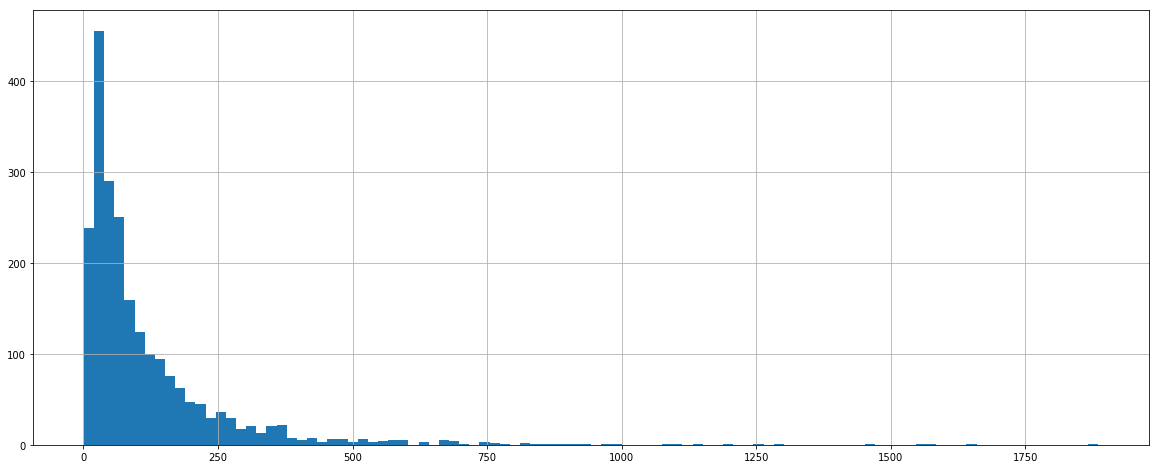

In [26]:
geo_linhas.renda_dompp_km.hist(bins=100,figsize=(20,8))

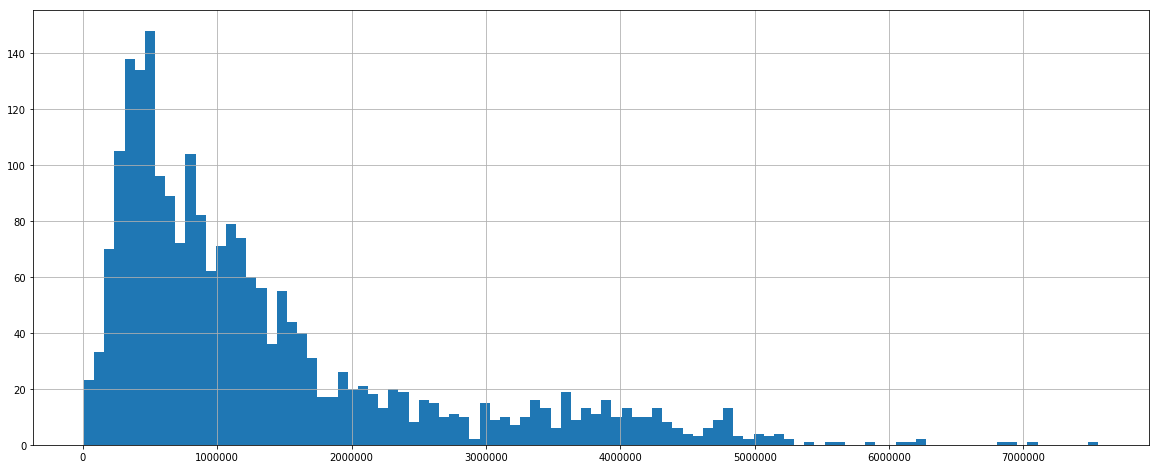

In [27]:
geo_linhas.sum_renda_dompp.hist(bins=100,figsize=(20,8))

In [28]:
geo_linhas.loc[geo_linhas.sum_renda_dompp.idxmax()]

distancia                                                         22142.8
id                                                                  63952
linhas                  LINESTRING (-46.805552 -23.585501, -46.805492 ...
route_id                                                          809T-10
service_id                                                            USD
trip_id                                                         809T-10-0
trip_headsign                                                        Lapa
direction_id                                                        False
geometry                POLYGON ((-46.80890429093454 -23.5823928645196...
sum_renda_dompp                                               7.55859e+06
prop_sum_renda_dompp                                          6.17658e+06
renda_dompp_km                                                     341.36
prop_renda_dompp_km                                                278.94
Name: 1748, dtype: object

In [29]:
geo_linhas.loc[geo_linhas.sum_renda_dompp.idxmin()]

distancia                                                         13784.2
id                                                                  68078
linhas                  LINESTRING (-46.506405 -23.585261, -46.50635 -...
route_id                                                          3029-10
service_id                                                            USD
trip_id                                                         3029-10-0
trip_headsign                                               Metrô Tatuapé
direction_id                                                        False
geometry                POLYGON ((-46.58289782203369 -23.5425437486358...
sum_renda_dompp                                                   8714.27
prop_sum_renda_dompp                                              4984.99
renda_dompp_km                                                       0.63
prop_renda_dompp_km                                                  0.36
Name: 494, dtype: object

In [30]:
geo_linhas.loc[geo_linhas.renda_dompp_km.idxmax()]

distancia                                                         3648.16
id                                                                  52774
linhas                  LINESTRING (-46.38742199999999 -23.521169, -46...
route_id                                                          2008-10
service_id                                                            USD
trip_id                                                         2008-10-0
trip_headsign                                         Cptm Itaim Paulista
direction_id                                                        False
geometry                POLYGON ((-46.40524701411066 -23.4956124081898...
sum_renda_dompp                                               6.87878e+06
prop_sum_renda_dompp                                          5.35237e+06
renda_dompp_km                                                    1885.55
prop_renda_dompp_km                                               1467.14
Name: 202, dtype: object

In [31]:
geo_linhas.loc[geo_linhas.renda_dompp_km.idxmin()]

distancia                                                         13784.2
id                                                                  68078
linhas                  LINESTRING (-46.506405 -23.585261, -46.50635 -...
route_id                                                          3029-10
service_id                                                            USD
trip_id                                                         3029-10-0
trip_headsign                                               Metrô Tatuapé
direction_id                                                        False
geometry                POLYGON ((-46.58289782203369 -23.5425437486358...
sum_renda_dompp                                                   8714.27
prop_sum_renda_dompp                                              4984.99
renda_dompp_km                                                       0.63
prop_renda_dompp_km                                                  0.36
Name: 494, dtype: object

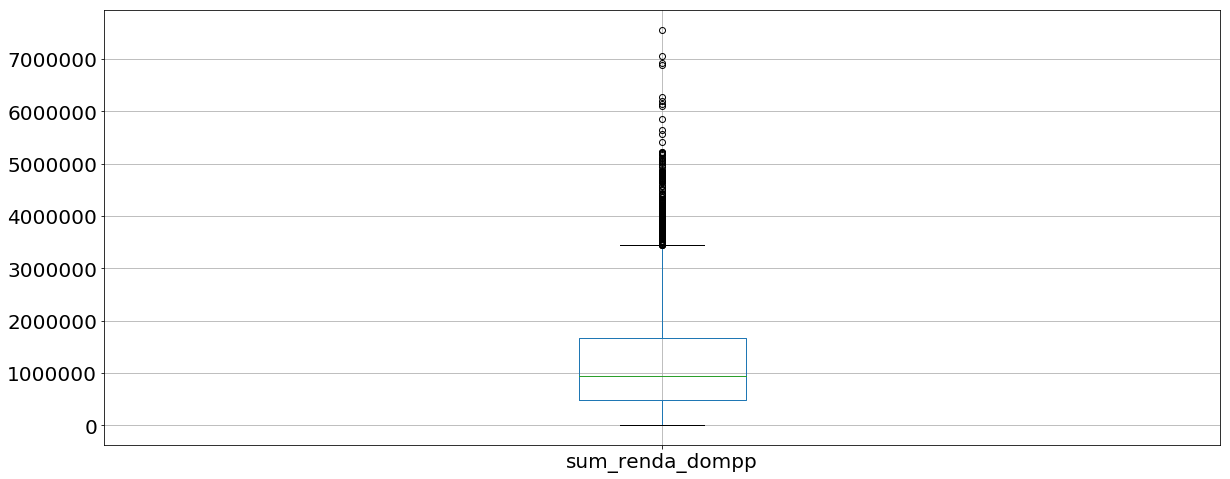

In [32]:
geo_linhas[['sum_renda_dompp']].boxplot(figsize=(20,8), fontsize=20)

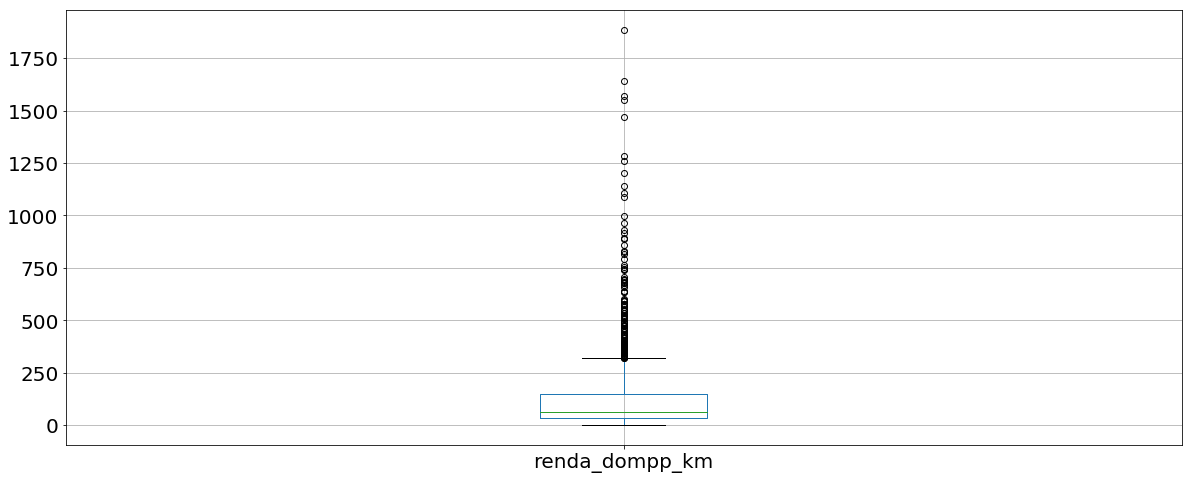

In [33]:
geo_linhas[['renda_dompp_km']].boxplot(figsize=(20,8), fontsize=20)

In [34]:
df_linhas.loc[df_linhas.prop_renda_dompp_km.idxmax()]

distancia                                                          6232.7
id                                                                  68207
linhas                  LINESTRING (-46.60288 -23.60308, -46.602832 -2...
route_id                                                          5031-10
service_id                                                            USD
trip_id                                                         5031-10-1
trip_headsign                                                  Vl. Arapuá
direction_id                                                         True
geometry                POLYGON ((-46.60286763500403 -23.6083919891361...
sum_renda_dompp                                               2.67937e+06
prop_sum_renda_dompp                                           5.5461e+11
renda_dompp_km                                                     429.89
prop_renda_dompp_km                                           8.89838e+07
Name: 906, dtype: object

In [36]:
df_linhas.loc[df_linhas.prop_renda_dompp_km.idxmin()]

distancia                                                         13784.2
id                                                                  68078
linhas                  LINESTRING (-46.506405 -23.585261, -46.50635 -...
route_id                                                          3029-10
service_id                                                            USD
trip_id                                                         3029-10-0
trip_headsign                                               Metrô Tatuapé
direction_id                                                        False
geometry                POLYGON ((-46.58289782203369 -23.5425437486358...
sum_renda_dompp                                                   8714.27
prop_sum_renda_dompp                                              48898.9
renda_dompp_km                                                       0.63
prop_renda_dompp_km                                                  3.55
Name: 494, dtype: object

In [35]:
df_linhas.loc[df_linhas.prop_sum_renda_dompp.idxmax()].prop_renda_dompp_km

distancia                                                         7446.55
id                                                                  64660
linhas                  LINESTRING (-46.420708 -23.529161, -46.420731 ...
route_id                                                          2703-21
service_id                                                            U__
trip_id                                                         2703-21-0
trip_headsign                                              Metrô Itaquera
direction_id                                                        False
geometry                POLYGON ((-46.47403065234133 -23.5466609956735...
sum_renda_dompp                                               2.34018e+06
prop_sum_renda_dompp                                          5.54665e+11
renda_dompp_km                                                     314.26
prop_renda_dompp_km                                           7.44862e+07
Name: 342, dtype: object